In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [52]:
base_path = Path('../../data/raw')

dfs = []
for file in sorted(base_path.glob('data_pos_*.csv')):
    df = pd.read_csv(file)
    dfs.append(df) 

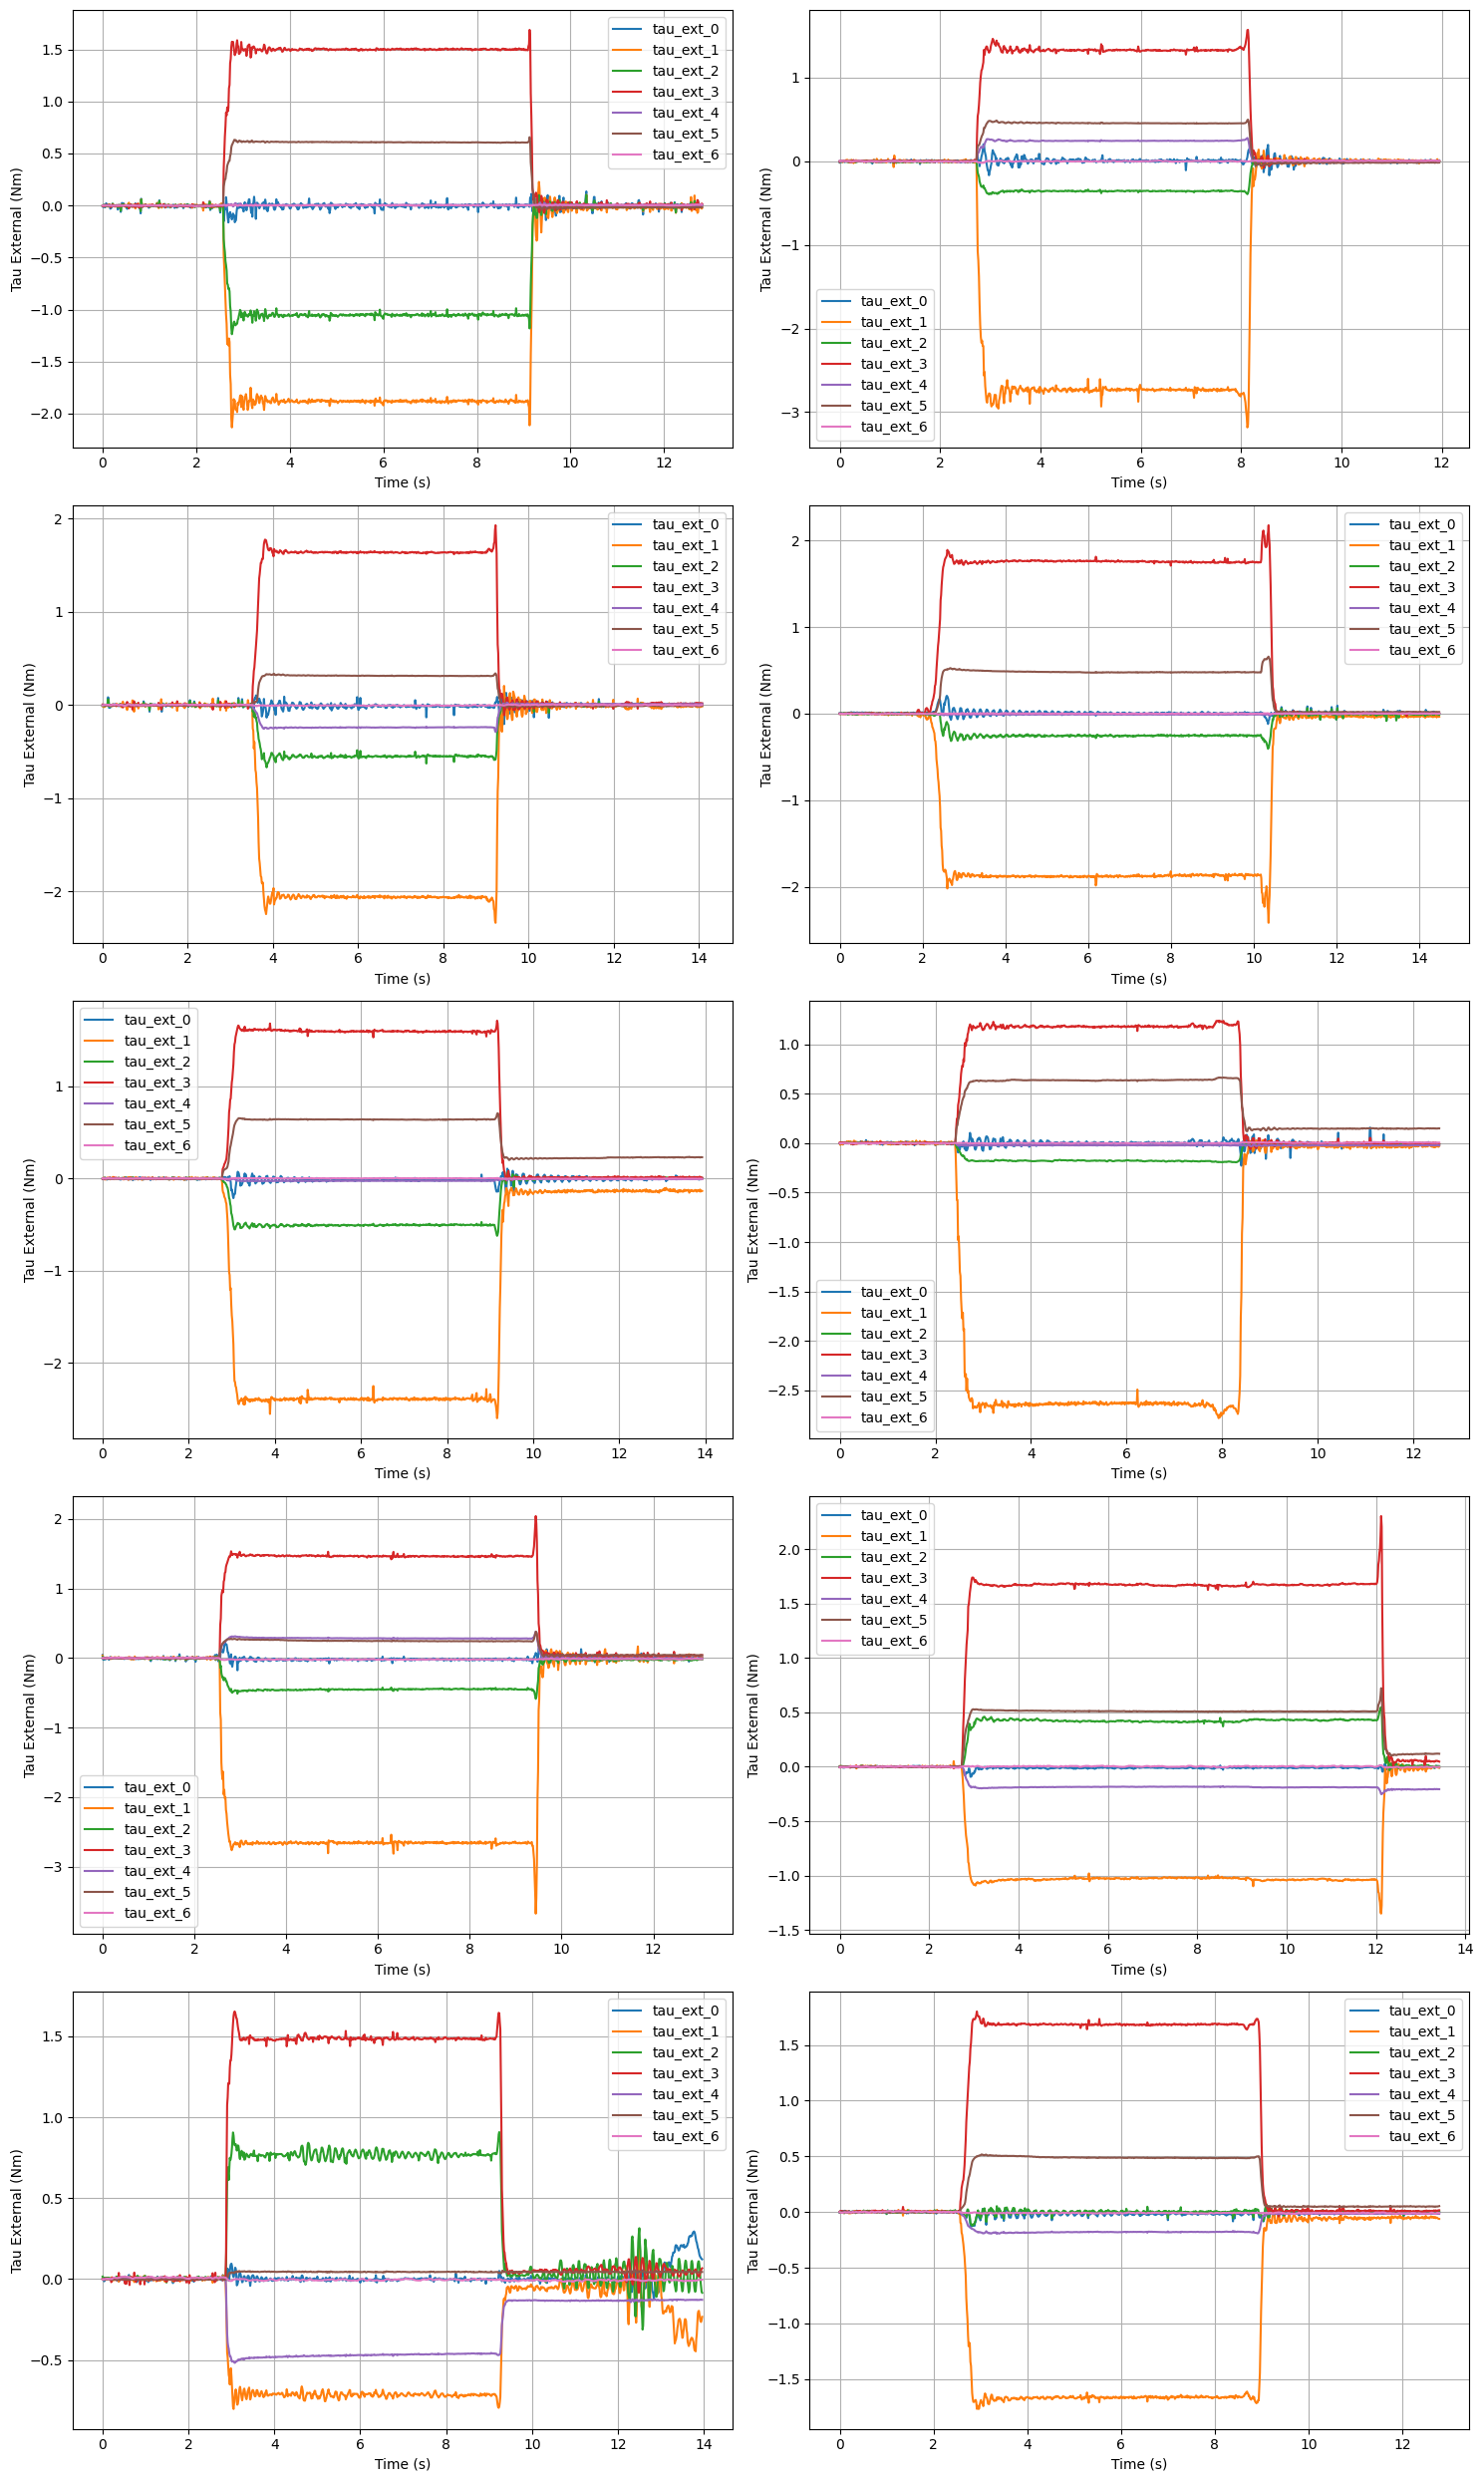

In [53]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.flatten()

for i, df in enumerate(dfs):
   # Reset timestamp to start at 0
   df['timestamp'] = df['timestamp'] - df['timestamp'].min()
   
   for j in range(7):
       axes[i].plot(df['timestamp'], df[f'tau_ext_{j}'], label=f'tau_ext_{j}')
   
   #axes[i].set_title(f'Tau External vs Time')
   axes[i].set_xlabel('Time (s)')
   axes[i].set_ylabel('Tau External (Nm)')
   axes[i].legend()
   axes[i].grid(True)

plt.tight_layout()
plt.show()

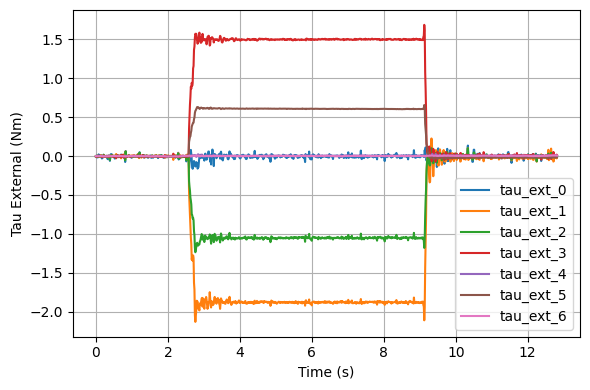

In [54]:
fig, ax = plt.subplots(figsize=(6, 4))

# Use only the first dataframe
df = dfs[0]

# Reset timestamp to start at 0
df['timestamp'] = df['timestamp'] - df['timestamp'].min()

# Plot all tau_ext columns
for j in range(7):
    ax.plot(df['timestamp'], df[f'tau_ext_{j}'], label=f'tau_ext_{j}')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Tau External (Nm)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

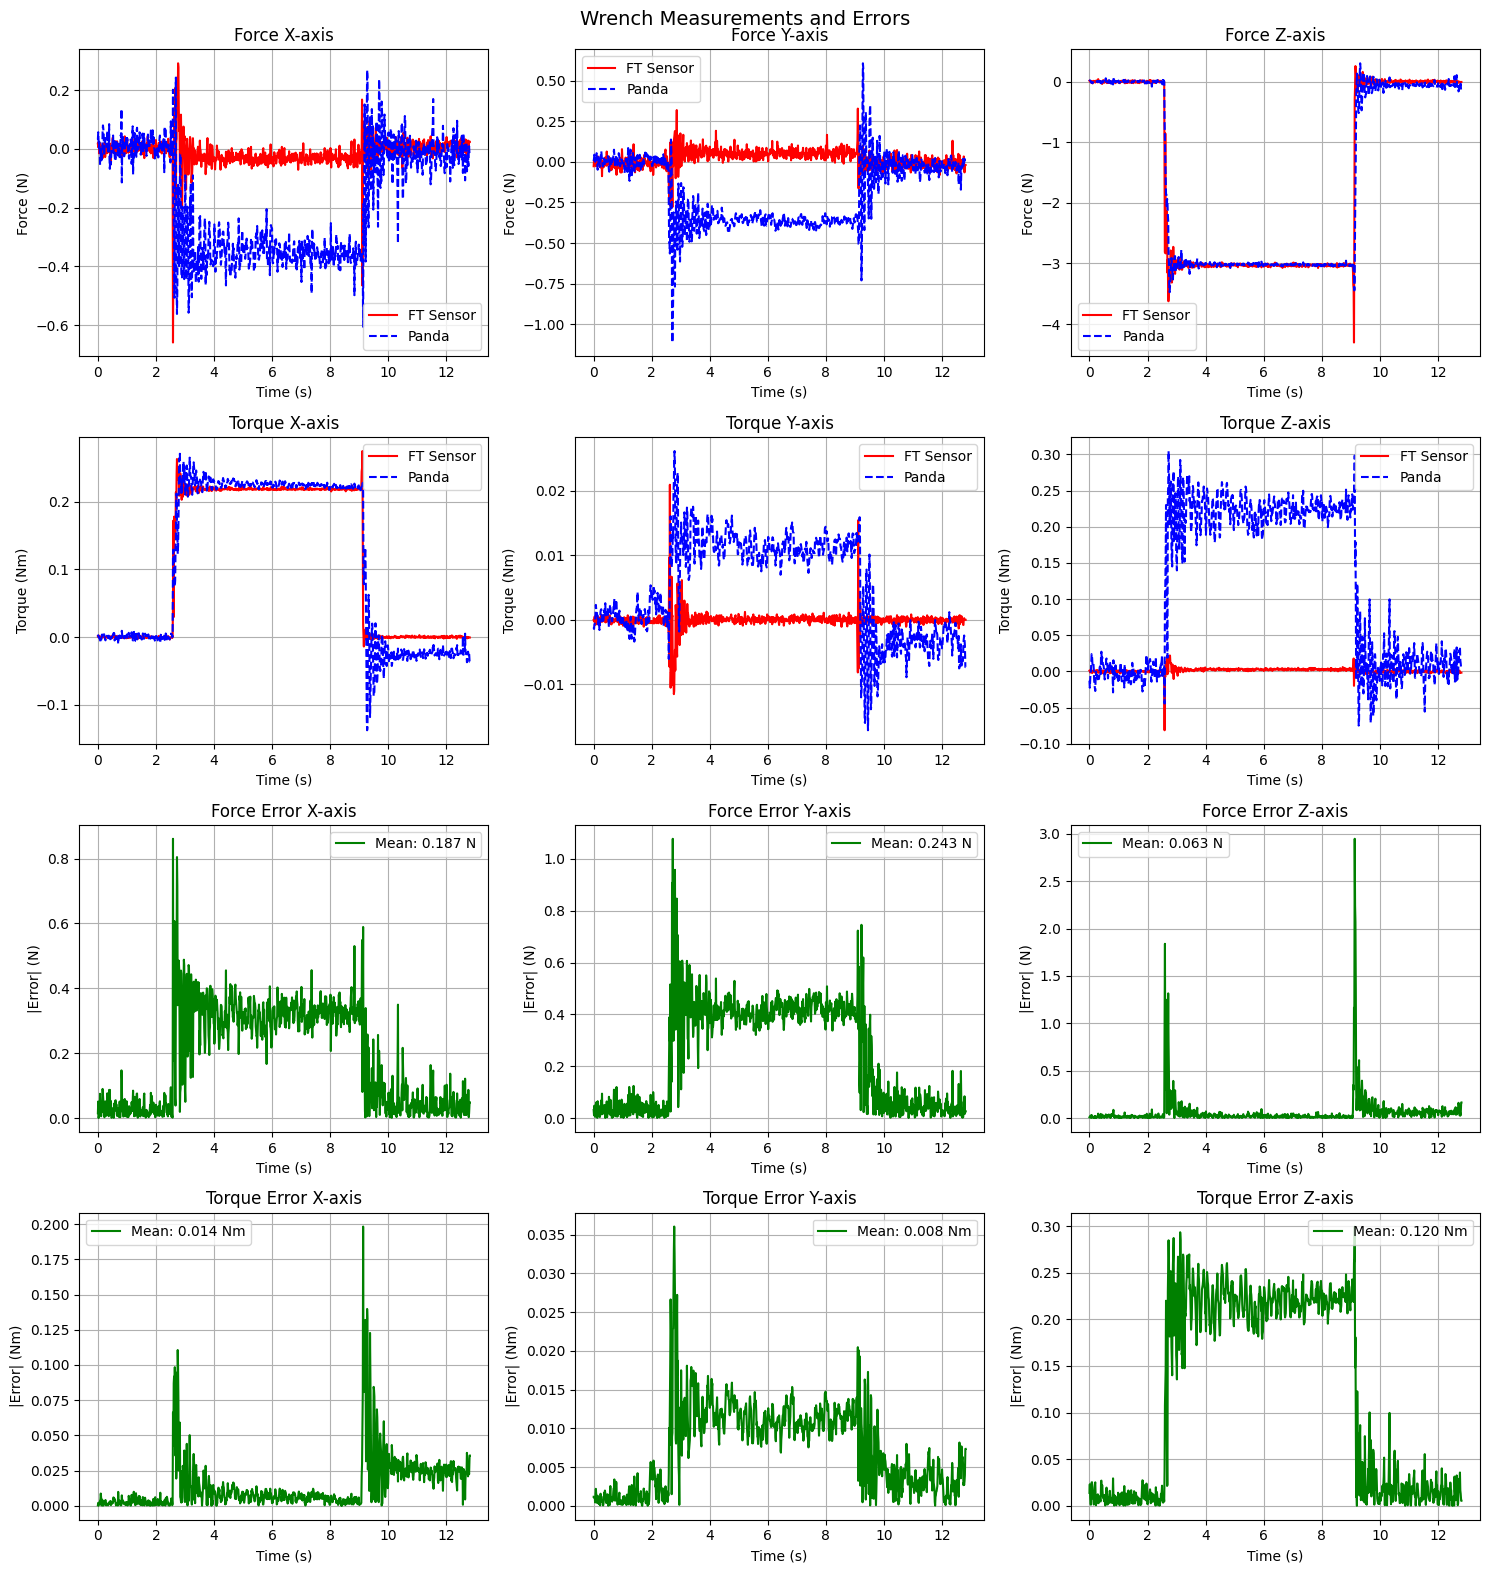

In [71]:
def plot_wrench_and_error(df):
   # Time normalization
   time = df['timestamp'] - df['timestamp'].min()
   
   fig, axes = plt.subplots(4, 3, figsize=(15, 16))
   fig.suptitle('Wrench Measurements and Errors', fontsize=14)
   
   for idx, axis in enumerate(['x', 'y', 'z']):
       # Forces
       axes[0, idx].plot(time, df[f'ft_wrench_force_{axis}'], 'r-', label='FT Sensor')
       axes[0, idx].plot(time, df[f'panda_wrench_force_{axis}'], 'b--', label='Panda')
       axes[0, idx].set_title(f'Force {axis.upper()}-axis')
       axes[0, idx].set_xlabel('Time (s)')
       axes[0, idx].set_ylabel('Force (N)')
       axes[0, idx].grid(True)
       axes[0, idx].legend()

       # Torques
       axes[1, idx].plot(time, df[f'ft_wrench_torque_{axis}'], 'r-', label='FT Sensor')
       axes[1, idx].plot(time, df[f'panda_wrench_torque_{axis}'], 'b--', label='Panda')
       axes[1, idx].set_title(f'Torque {axis.upper()}-axis')
       axes[1, idx].set_xlabel('Time (s)')
       axes[1, idx].set_ylabel('Torque (Nm)')
       axes[1, idx].grid(True)
       axes[1, idx].legend()

       # Force errors
       force_error = np.abs(df[f'panda_wrench_force_{axis}'] - df[f'ft_wrench_force_{axis}'])
       mean_force_error = force_error.mean()
       axes[2, idx].plot(time, force_error, 'g-')
       axes[2, idx].set_title(f'Force Error {axis.upper()}-axis')
       axes[2, idx].set_xlabel('Time (s)')
       axes[2, idx].set_ylabel('|Error| (N)')
       axes[2, idx].grid(True)
       axes[2, idx].legend([f'Mean: {mean_force_error:.3f} N'])

       # Torque errors
       torque_error = np.abs(df[f'panda_wrench_torque_{axis}'] - df[f'ft_wrench_torque_{axis}'])
       mean_torque_error = torque_error.mean()
       axes[3, idx].plot(time, torque_error, 'g-')
       axes[3, idx].set_title(f'Torque Error {axis.upper()}-axis')
       axes[3, idx].set_xlabel('Time (s)')
       axes[3, idx].set_ylabel('|Error| (Nm)')
       axes[3, idx].grid(True)
       axes[3, idx].legend([f'Mean: {mean_torque_error:.3f} Nm'])

   plt.tight_layout()
   plt.show()

# Use with first dataset
# for df in dfs:
#     plot_wrench_and_error(df)
plot_wrench_and_error(dfs[0])

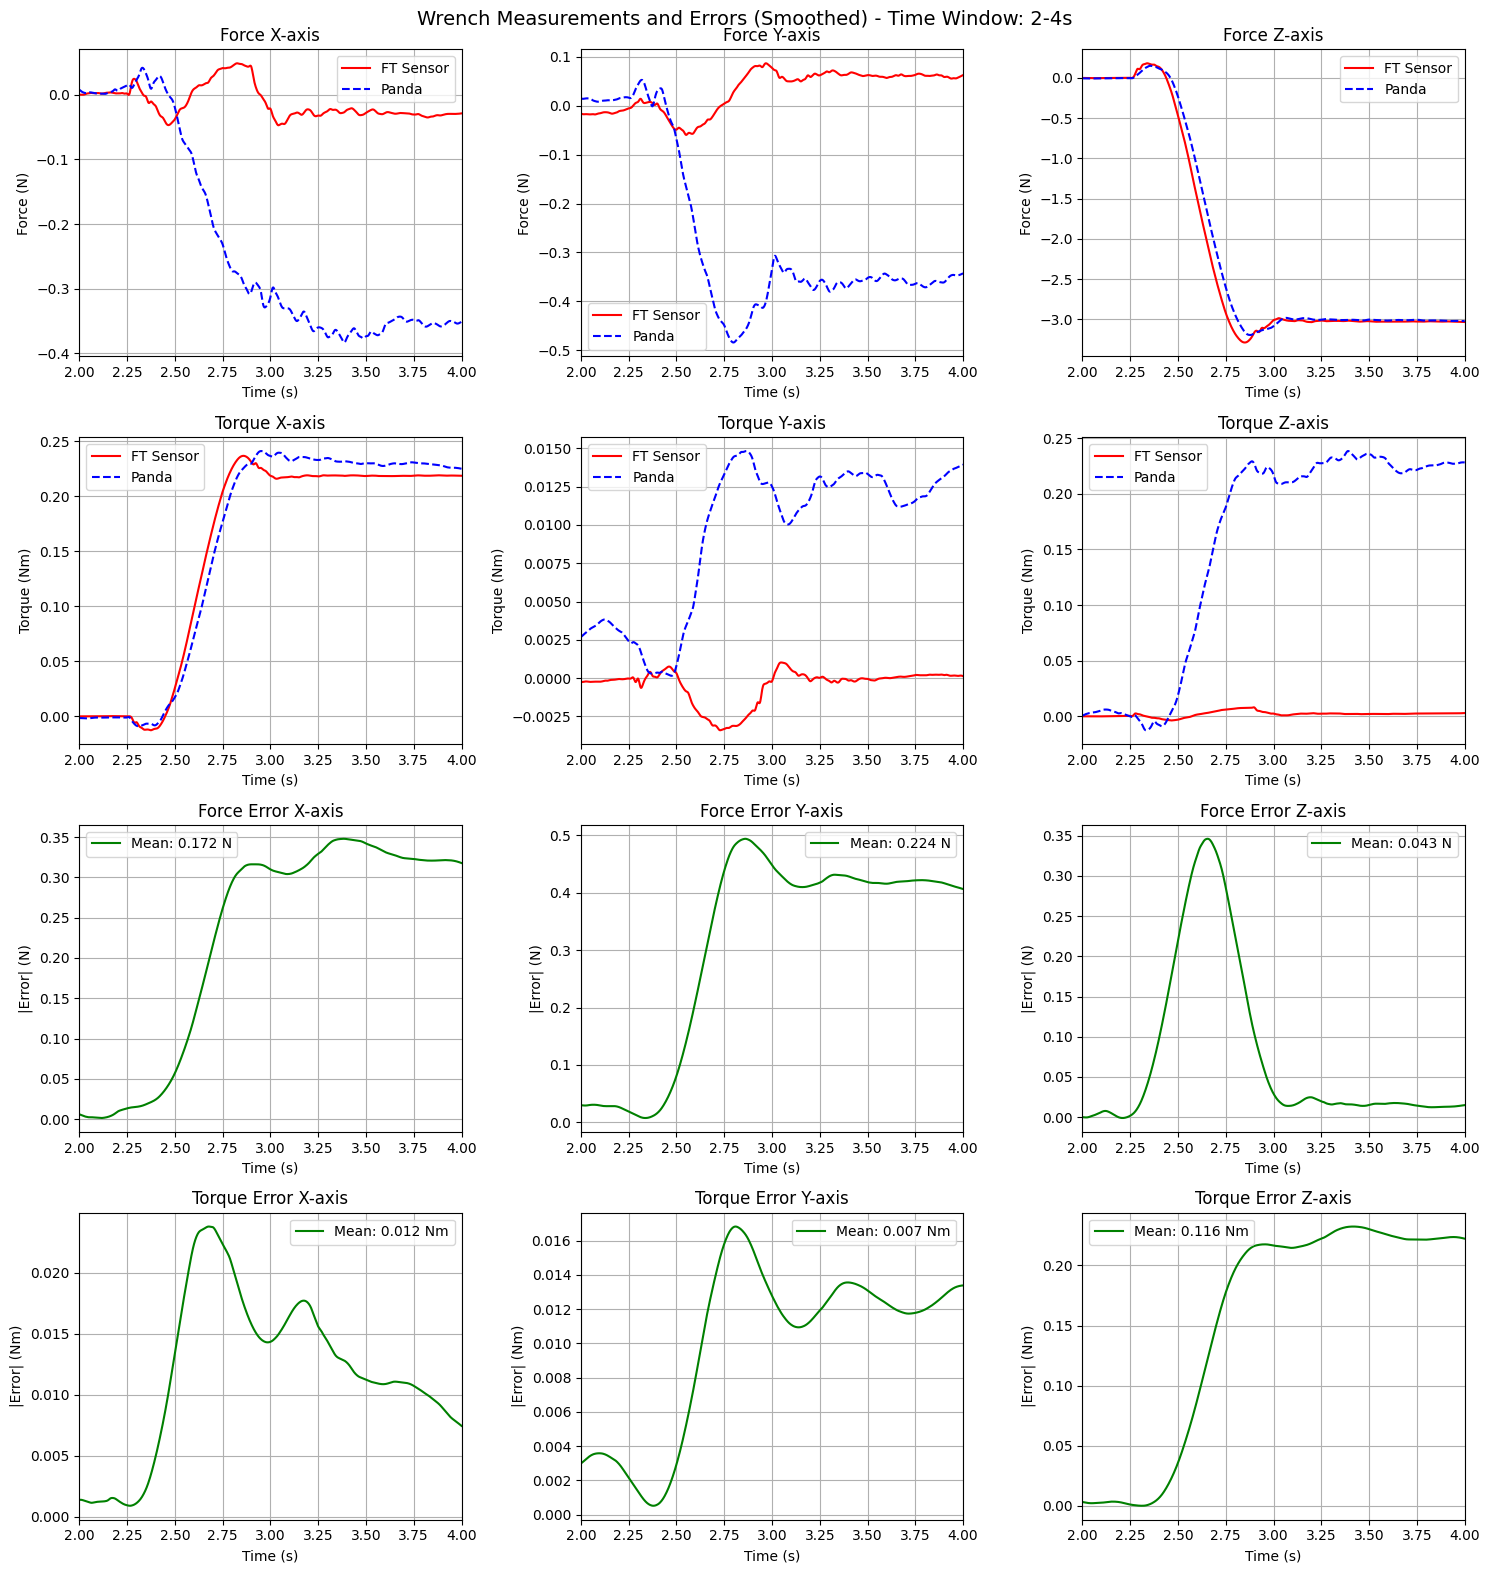

In [72]:
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

def plot_wrench_and_error(df):
    # Time normalization
    time = df['timestamp'] - df['timestamp'].min()
    
    # Create smoother time points for interpolation, focusing on 2-4 seconds
    t_smooth = np.linspace(2, 4, 1000)
    
    fig, axes = plt.subplots(4, 3, figsize=(15, 16))
    fig.suptitle('Wrench Measurements and Errors (Smoothed) - Time Window: 2-4s', fontsize=14)
    
    for idx, axis in enumerate(['x', 'y', 'z']):
        # Forces - smooth and interpolate both signals
        ft_force = savgol_filter(df[f'ft_wrench_force_{axis}'], window_length=51, polyorder=3)
        panda_force = savgol_filter(df[f'panda_wrench_force_{axis}'], window_length=51, polyorder=3)
        
        ft_force_interp = interp1d(time, ft_force, kind='cubic')
        panda_force_interp = interp1d(time, panda_force, kind='cubic')
        
        axes[0, idx].plot(t_smooth, ft_force_interp(t_smooth), 'r-', label='FT Sensor')
        axes[0, idx].plot(t_smooth, panda_force_interp(t_smooth), 'b--', label='Panda')
        axes[0, idx].set_title(f'Force {axis.upper()}-axis')
        axes[0, idx].set_xlabel('Time (s)')
        axes[0, idx].set_ylabel('Force (N)')
        axes[0, idx].grid(True)
        axes[0, idx].legend()
        axes[0, idx].set_xlim(2, 4)  # Set x-axis limits

        # Torques - smooth and interpolate both signals
        ft_torque = savgol_filter(df[f'ft_wrench_torque_{axis}'], window_length=51, polyorder=3)
        panda_torque = savgol_filter(df[f'panda_wrench_torque_{axis}'], window_length=51, polyorder=3)
        
        ft_torque_interp = interp1d(time, ft_torque, kind='cubic')
        panda_torque_interp = interp1d(time, panda_torque, kind='cubic')
        
        axes[1, idx].plot(t_smooth, ft_torque_interp(t_smooth), 'r-', label='FT Sensor')
        axes[1, idx].plot(t_smooth, panda_torque_interp(t_smooth), 'b--', label='Panda')
        axes[1, idx].set_title(f'Torque {axis.upper()}-axis')
        axes[1, idx].set_xlabel('Time (s)')
        axes[1, idx].set_ylabel('Torque (Nm)')
        axes[1, idx].grid(True)
        axes[1, idx].legend()
        axes[1, idx].set_xlim(2, 4)  # Set x-axis limits

        # Force errors - smooth and interpolate
        force_error = np.abs(panda_force - ft_force)
        force_error_smooth = savgol_filter(force_error, window_length=51, polyorder=3)
        force_error_interp = interp1d(time, force_error_smooth, kind='cubic')
        mean_force_error = force_error.mean()
        
        axes[2, idx].plot(t_smooth, force_error_interp(t_smooth), 'g-')
        axes[2, idx].set_title(f'Force Error {axis.upper()}-axis')
        axes[2, idx].set_xlabel('Time (s)')
        axes[2, idx].set_ylabel('|Error| (N)')
        axes[2, idx].grid(True)
        axes[2, idx].legend([f'Mean: {mean_force_error:.3f} N'])
        axes[2, idx].set_xlim(2, 4)  # Set x-axis limits

        # Torque errors - smooth and interpolate
        torque_error = np.abs(panda_torque - ft_torque)
        torque_error_smooth = savgol_filter(torque_error, window_length=51, polyorder=3)
        torque_error_interp = interp1d(time, torque_error_smooth, kind='cubic')
        mean_torque_error = torque_error.mean()
        
        axes[3, idx].plot(t_smooth, torque_error_interp(t_smooth), 'g-')
        axes[3, idx].set_title(f'Torque Error {axis.upper()}-axis')
        axes[3, idx].set_xlabel('Time (s)')
        axes[3, idx].set_ylabel('|Error| (Nm)')
        axes[3, idx].grid(True)
        axes[3, idx].legend([f'Mean: {mean_torque_error:.3f} Nm'])
        axes[3, idx].set_xlim(2, 4)  # Set x-axis limits

    plt.tight_layout()
    plt.show()

# Plot only the first dataset
plot_wrench_and_error(dfs[0])

In [49]:
for i in range(len(dfs)):
   dfs[i] = dfs[i][~((dfs[i]['ft_x'] == 0) & (dfs[i]['ft_y'] == 0))]

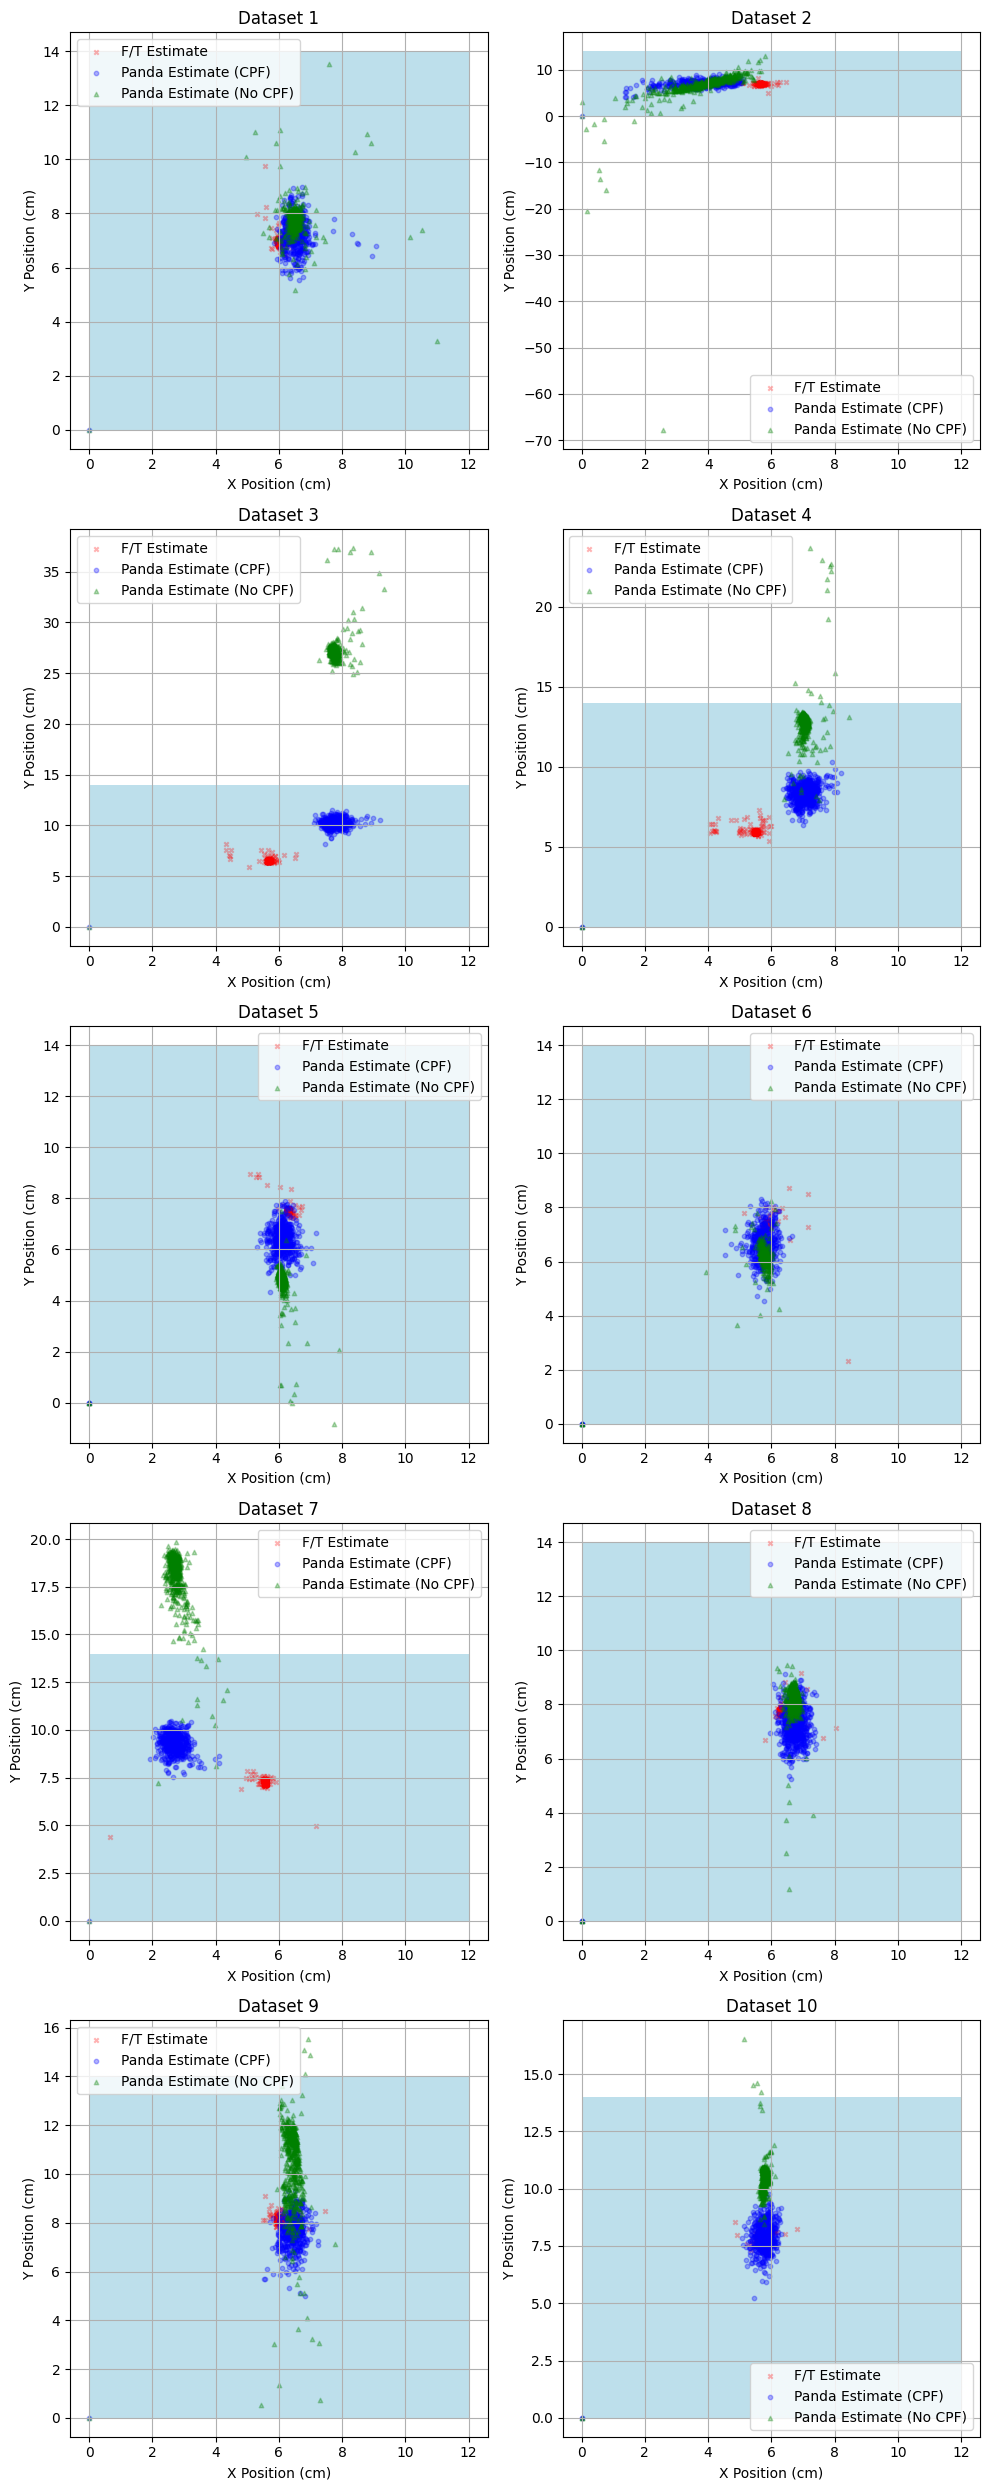

In [36]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(5, 2, figsize=(10, 25))
axes = axes.flatten()

for i, df in enumerate(dfs):
   # Convert m to cm
   ft_x_cm = df['ft_x'] * 100
   ft_y_cm = df['ft_y'] * 100
   panda_x_cm = df['panda_x'] * 100
   panda_y_cm = df['panda_y'] * 100
   raw_x_cm = df['raw_contact_x'] * 100
   raw_y_cm = df['raw_contact_y'] * 100
   
   rect = Rectangle((0, 0), 12, 14, facecolor='lightblue', alpha=0.8)
   axes[i].add_patch(rect)
   
   axes[i].scatter(ft_x_cm, ft_y_cm, c='red', label='F/T Estimate', alpha=0.3, marker='x', s=10)
   axes[i].scatter(panda_x_cm, panda_y_cm, c='blue', label='Panda Estimate (CPF)', alpha=0.3, marker='o', s=10)
   axes[i].scatter(raw_x_cm, raw_y_cm, c='green', label='Panda Estimate (No CPF)', alpha=0.3, marker='^', s=10)
   
   axes[i].set_title(f'Dataset {i+1}')
   axes[i].set_xlabel('X Position (cm)')
   axes[i].set_ylabel('Y Position (cm)')
   axes[i].legend()
   axes[i].grid(True)
   

plt.tight_layout()
plt.show()

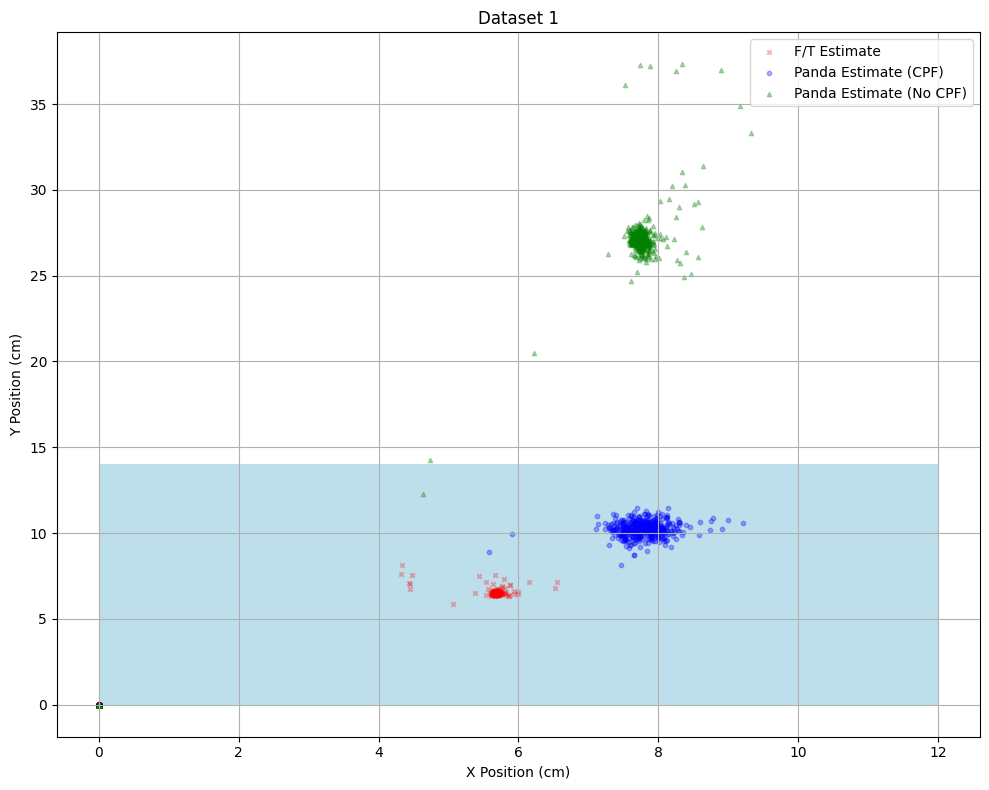

In [77]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(10, 8))

# Using only the first dataframe (dfs[0])
df = dfs[2]

# Convert m to cm
ft_x_cm = df['ft_x'] * 100
ft_y_cm = df['ft_y'] * 100
panda_x_cm = df['panda_x'] * 100
panda_y_cm = df['panda_y'] * 100
raw_x_cm = df['raw_contact_x'] * 100
raw_y_cm = df['raw_contact_y'] * 100

# Add rectangle
rect = Rectangle((0, 0), 12, 14, facecolor='lightblue', alpha=0.8)
ax.add_patch(rect)

# Plot scatter points
ax.scatter(ft_x_cm, ft_y_cm, c='red', label='F/T Estimate', alpha=0.3, marker='x', s=10)
ax.scatter(panda_x_cm, panda_y_cm, c='blue', label='Panda Estimate (CPF)', alpha=0.3, marker='o', s=10)
ax.scatter(raw_x_cm, raw_y_cm, c='green', label='Panda Estimate (No CPF)', alpha=0.3, marker='^', s=10)

ax.set_title('Dataset 1')
ax.set_xlabel('X Position (cm)')
ax.set_ylabel('Y Position (cm)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

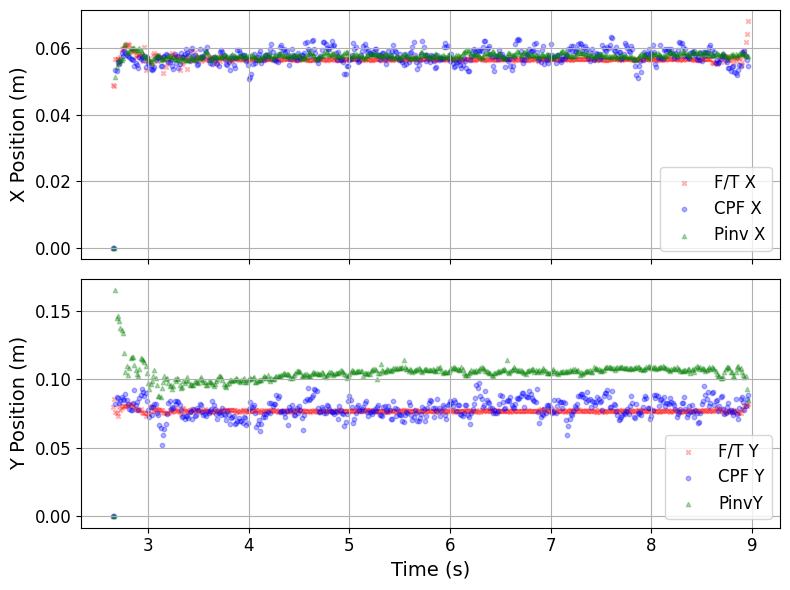

In [94]:
# Create a figure with 2 subplots (one for x coordinates, one for y coordinates)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Create mask for time range 2-10 seconds
mask = (df['ft_x'] != 0) & (df['ft_y'] != 0)

# Plot X coordinates over time
ax1.scatter(df.loc[mask, 'timestamp'], df.loc[mask, 'ft_x'], c='red', label='F/T X', alpha=0.3, marker='x', s=10)
ax1.scatter(df.loc[mask, 'timestamp'], df.loc[mask, 'panda_x'], c='blue', label='CPF X', alpha=0.3, marker='o', s=10)
ax1.scatter(df.loc[mask, 'timestamp'], df.loc[mask, 'raw_contact_x'], c='green', label='Pinv X', alpha=0.3, marker='^', s=10)
ax1.set_ylabel('X Position (m)', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot Y coordinates over time
ax2.scatter(df.loc[mask, 'timestamp'], df.loc[mask, 'ft_y'], c='red', label='F/T Y', alpha=0.3, marker='x', s=10)
ax2.scatter(df.loc[mask, 'timestamp'], df.loc[mask, 'panda_y'], c='blue', label='CPF Y', alpha=0.3, marker='o', s=10)
ax2.scatter(df.loc[mask, 'timestamp'], df.loc[mask, 'raw_contact_y'], c='green', label='PinvY', alpha=0.3, marker='^', s=10)
ax2.set_xlabel('Time (s)', fontsize=14)
ax2.set_ylabel('Y Position (m)', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('../../img/CPF_Raw.png', dpi=600, bbox_inches='tight', format='png')
plt.show()

In [78]:
rmse_x_list = []
rmse_y_list = []
error_norm_list = []

for df in dfs:
   # Calculate errors
   error_x = (df['ft_x'] - df['panda_x']) * 1000  # in cm
   error_y = (df['ft_y'] - df['panda_y']) * 1000  # in cm
   error_norm = np.sqrt(error_x**2 + error_y**2)
   
   # Calculate RMSE
   rmse_x = np.sqrt(np.mean(error_x**2))
   rmse_y = np.sqrt(np.mean(error_y**2))
   mean_error_norm = np.mean(error_norm)
   
   rmse_x_list.append(rmse_x)
   rmse_y_list.append(rmse_y)
   error_norm_list.append(mean_error_norm)

print(f"Average RMSE X: {np.mean(rmse_x_list):.2f} ± {np.std(rmse_x_list):.2f} mm")
print(f"Average RMSE Y: {np.mean(rmse_y_list):.2f} ± {np.std(rmse_y_list):.2f} mm")
print(f"Average Error Norm: {np.mean(error_norm_list):.2f} ± {np.std(error_norm_list):.2f} mm")
print(f"Max Error: {np.max(error_norm_list):.2f} mm")

Average RMSE X: 16.63 ± 9.91 mm
Average RMSE Y: 28.45 ± 23.63 mm
Average Error Norm: 20.54 ± 15.27 mm
Max Error: 46.85 mm


In [79]:

rmse_x_list_ft_raw = []
rmse_y_list_ft_raw = []
error_norm_list_ft_raw = []

for df in dfs:
   # Calculate errors between FT and raw contact
   error_x = (df['ft_x'] - df['raw_contact_x']) * 1000 
   error_y = (df['ft_y'] - df['raw_contact_y']) * 1000 
   error_norm = np.sqrt(error_x**2 + error_y**2)
   
   rmse_x = np.sqrt(np.mean(error_x**2))
   rmse_y = np.sqrt(np.mean(error_y**2))
   mean_error_norm = np.mean(error_norm)
   
   rmse_x_list_ft_raw.append(rmse_x)
   rmse_y_list_ft_raw.append(rmse_y)
   error_norm_list_ft_raw.append(mean_error_norm)

print("FT vs Raw Contact:")
print(f"Average RMSE X: {np.mean(rmse_x_list_ft_raw):.2f} mm")
print(f"Average RMSE Y: {np.mean(rmse_y_list_ft_raw):.2f} mm")
print(f"Average Error Norm: {np.mean(error_norm_list_ft_raw):.2f} + {np.std(error_norm_list_ft_raw):.2f} mm")
print(f"Max Error: {np.max(error_norm_list_ft_raw):.2f} mm")

FT vs Raw Contact:
Average RMSE X: 72.21 mm
Average RMSE Y: 391.83 mm
Average Error Norm: 126.84 + 125.85 mm
Max Error: 410.37 mm
